# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

Objective: Perform a what-if analysis to understand the impact of removing the worst-performing sellers.


### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

##### Step 0 : Import Libraries

In [1]:
import pandas as pd
import numpy as np
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Seller class
seller = Seller()

# Get the training data
training_data = seller.get_training_data()
training_data.head()


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_reviews,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.000000,0,341.870,341.870
1,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.000000,100,341.870,241.870
2,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.000000,40,341.870,301.870
3,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.731707,0.048780,4.560976,0,2290.307,2290.307
4,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.731707,0.048780,4.560976,0,2290.307,2290.307


In [2]:
training_data.describe()

,delay_to_carrier,wait_time,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_reviews,revenues,profits
count,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000,99642.000000
mean,0.054408,12.468645,13.730545,375.528321,422.947803,1.126301,40692.618964,0.569350,0.122379,4.050576,16.240240,5167.705525,5151.465285
std,0.705657,3.381839,5.867729,491.069523,557.455554,0.171652,55245.764429,0.119602,0.082985,0.373079,32.855336,5727.722886,5727.432610
min,0.000000,1.214178,0.000000,1.000000,1.000000,1.000000,6.500000,0.000000,0.000000,1.000000,0.000000,0.650000,-99.310000
25%,0.000000,10.383809,10.000000,51.000000,57.000000,1.037618,5039.900000,0.509434,0.077187,3.899767,0.000000,1543.990000,1509.405000
50%,0.000000,12.280722,15.000000,153.000000,173.000000,1.080460,14103.300000,0.569515,0.112883,4.071429,0.000000,2636.230000,2620.364000
75%,0.000000,14.297115,18.000000,473.000000,522.000000,1.164724,46610.400000,0.627907,0.148185,4.242424,0.000000,5835.195000,5835.195000
max,45.434039,189.863160,23.000000,1854.000000,2033.000000,15.000000,229472.630000,1.000000,1.000000,5.000000,100.000000,24387.263000,24387.263000


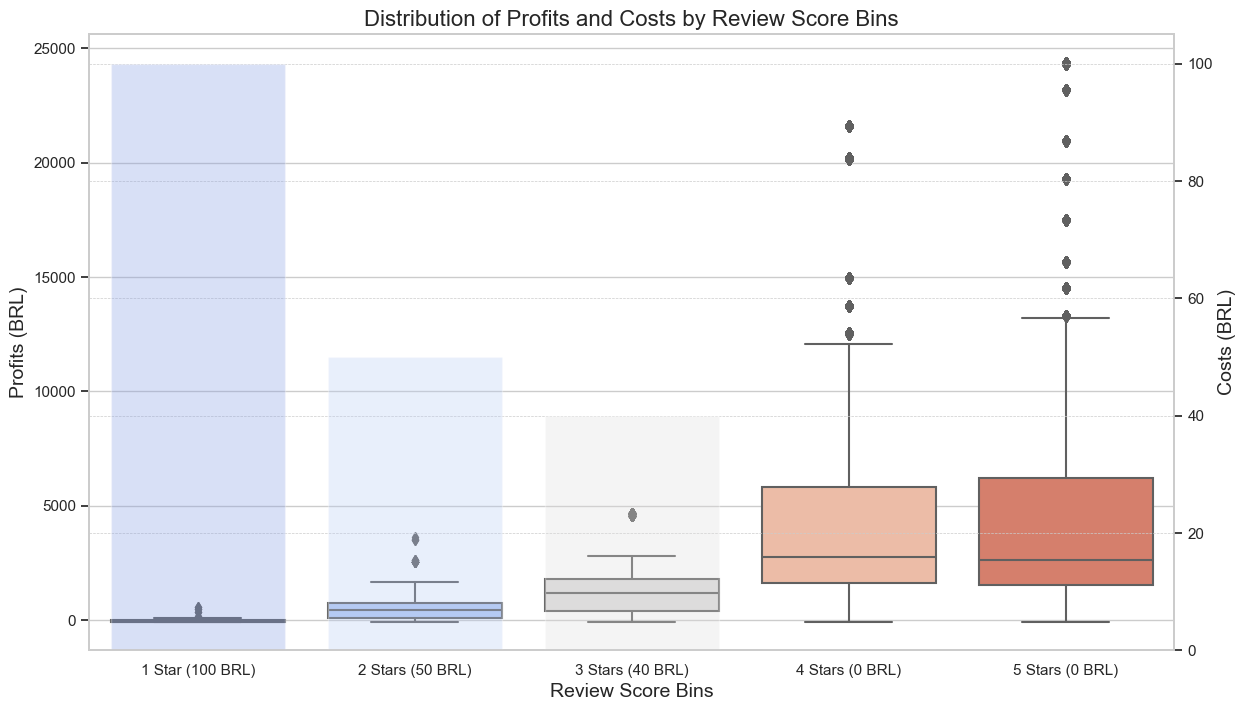

In [3]:
# Define new bins and labels
bins = [0, 1, 2, 3, 4, 5]
labels = ['1 Star (100 BRL)', '2 Stars (50 BRL)', '3 Stars (40 BRL)', '4 Stars (0 BRL)', '5 Stars (0 BRL)']

# Create a new column in the training_data DataFrame for the review score bins
training_data['review_score_bin'] = pd.cut(training_data['review_score'], bins=bins, labels=labels, include_lowest=True)

# Group by the new review score bins and calculate the mean profits
grouped_review_profits = training_data.groupby('review_score_bin')['profits'].mean().reset_index()

# Calculate the total costs for each review score bin
costs = {'1 Star (100 BRL)': 100, '2 Stars (50 BRL)': 50, '3 Stars (40 BRL)': 40, '4 Stars (0 BRL)': 0, '5 Stars (0 BRL)': 0}
grouped_review_profits['costs'] = grouped_review_profits['review_score_bin'].map(costs)

# Set the style
sns.set(style="whitegrid")

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Box plot for profits
sns.boxplot(x='review_score_bin', y='profits', data=training_data, palette='coolwarm', ax=ax1)
ax1.set_xlabel('Review Score Bins', fontsize=14)
ax1.set_ylabel('Profits (BRL)', fontsize=14)
ax1.set_title('Distribution of Profits and Costs by Review Score Bins', fontsize=16)

# Bar plot for costs on the same plot
ax2 = ax1.twinx()
sns.barplot(x='review_score_bin', y='costs', data=grouped_review_profits, palette='coolwarm', ax=ax2, alpha=0.3)
ax2.set_ylabel('Costs (BRL)', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

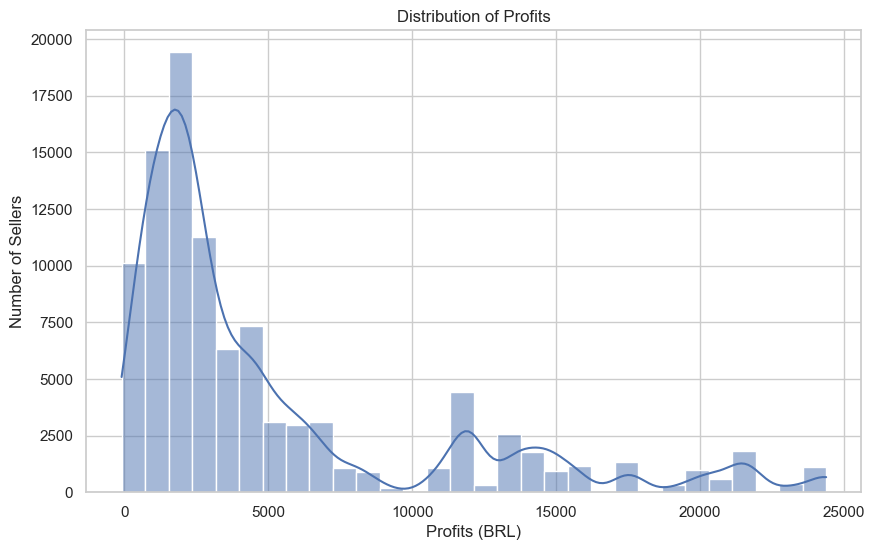

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(training_data['profits'], bins=30, kde=True)
plt.title('Distribution of Profits')
plt.xlabel('Profits (BRL)')
plt.ylabel('Number of Sellers')
plt.grid(True)
plt.show()

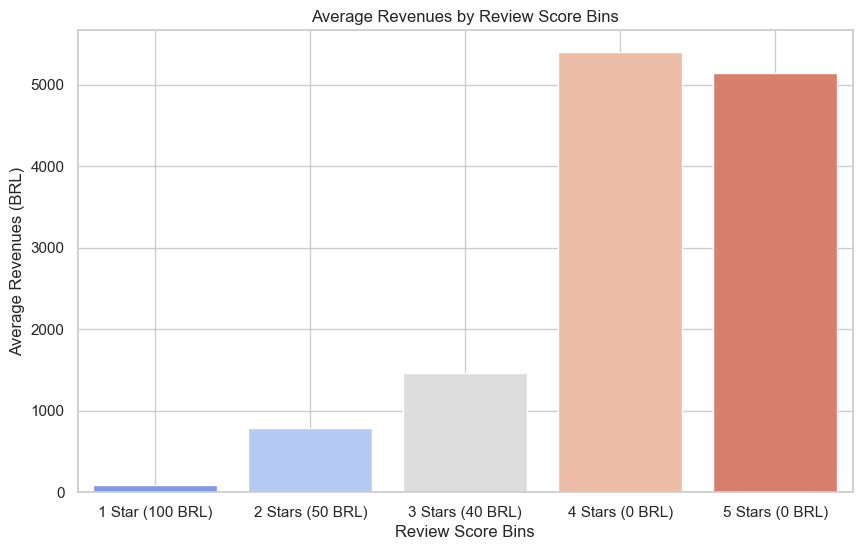

In [5]:
# Group the data by review score bins and calculate the average revenues
grouped_revenues = training_data.groupby('review_score_bin')['revenues'].mean().reset_index()

# Create a bar plot to visualize the average revenues for each review score bin
plt.figure(figsize=(10, 6))
sns.barplot(x='review_score_bin', y='revenues', data=grouped_revenues, palette='coolwarm')
plt.title('Average Revenues by Review Score Bins')
plt.xlabel('Review Score Bins')
plt.ylabel('Average Revenues (BRL)')
plt.grid(True)
plt.show()

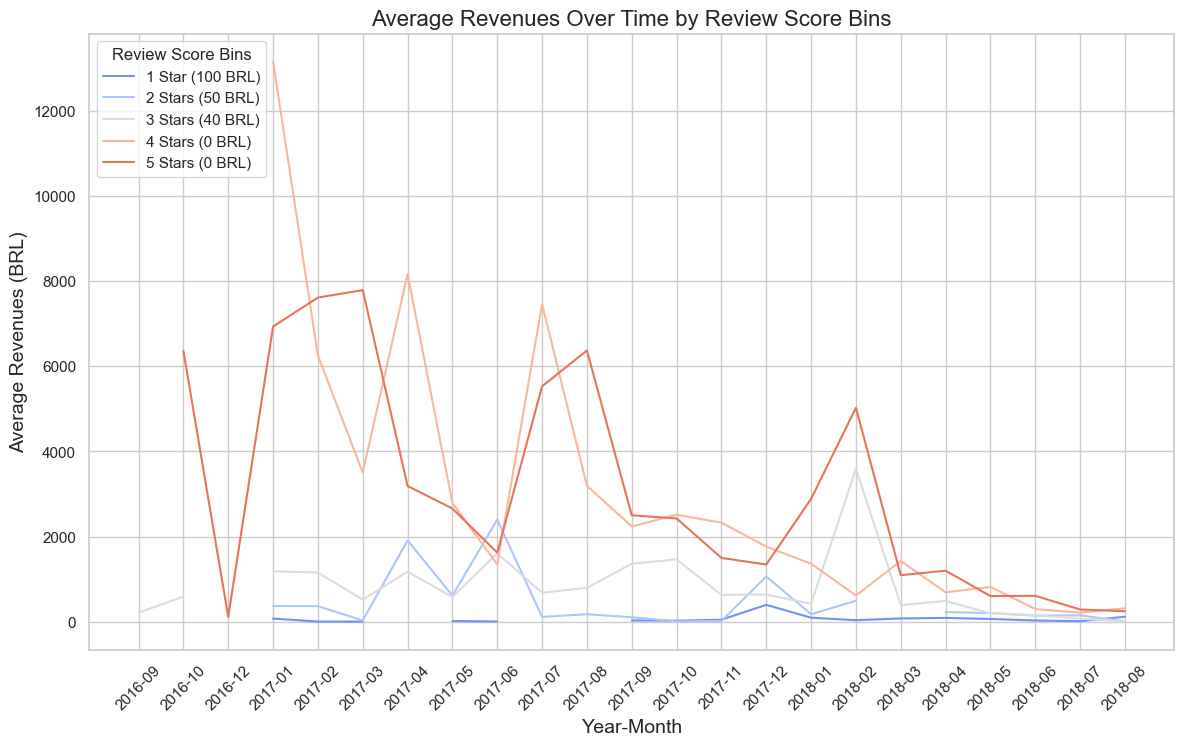

In [6]:
# Convert 'date_first_sale' to datetime and extract 'year_month'
training_data['year_month'] = pd.to_datetime(training_data['date_first_sale']).dt.to_period('M')

# Define the review score bins and labels
bins = [0, 1, 2, 3, 4, 5]
labels = ['1 Star (100 BRL)', '2 Stars (50 BRL)', '3 Stars (40 BRL)', '4 Stars (0 BRL)', '5 Stars (0 BRL)']
training_data['review_score_bin'] = pd.cut(training_data['review_score'], bins=bins, labels=labels, include_lowest=True)

# Group by review score bin and year_month, then calculate average revenues
grouped_revenues = training_data.groupby(['review_score_bin', 'year_month'])['revenues'].mean().reset_index()

# Pivot the table for easier plotting
pivot_revenues = grouped_revenues.pivot(index='year_month', columns='review_score_bin', values='revenues').astype(float)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot revenues on the primary y-axis
colors = sns.color_palette('coolwarm', len(pivot_revenues.columns))
for idx, column in enumerate(pivot_revenues.columns):
    ax1.plot(pivot_revenues.index.astype(str), pivot_revenues[column], color=colors[idx], label=column)
ax1.set_xlabel('Year-Month', fontsize=14)
ax1.set_ylabel('Average Revenues (BRL)', fontsize=14)
ax1.set_title('Average Revenues Over Time by Review Score Bins', fontsize=16)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# Add a legend
ax1.legend(title='Review Score Bins', loc='upper left')

plt.show()

**Average revenues over time for each review score bin, helping you observe the performance trends of different groups of sellers**

**Peaks and Fluctuations**: The peaks and fluctuations are more pronounced for sellers with 4 and 5-star reviews. This indicates that higher-rated sellers tend to have more variability in their performance, possibly due to higher sales volumes and more market influence.


**Consistent Low Revenues for Low Ratings**: Sellers with 1 and 2-star reviews show consistently low revenues with minimal improvement over time, reinforcing their underperformance.


**Overall Decline**: All review score bins show a general decline in revenues towards mid-2018, suggesting a broader trend affecting the platform’s sellers.


**Potential Actions**:

1. Investigate High Performers: Look into the factors contributing to the success of 4 and 5-star sellers during their peak periods to replicate or sustain these strategies.
2. Support for Low Performers: Implement targeted interventions to help improve the performance of consistently low-rated sellers or consider phasing them out if improvement is not feasible.
3. Address Overall Decline: Conduct a deeper analysis into the causes of the overall revenue decline to implement strategic measures for boosting seller performance across the board.

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

🚩 Goal: 

To maximize Olist’s overall profit by identifying the optimal number of underperforming sellers to remove.

💡 LOGIC:

1. **Initial set-up**: 

* Calculate the total profits from all sellers.

* Calculate the initial IT cost based on the total number of sellers and the total quantity of items

* Compute the initial net profit as total profits minus IT costs.
 

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$


profits = (revenues - costs)

2. **Sort Sellers**:

* Sort sellers in ascending order by their profits. This means the least profitable sellers are considered first.


3. **Iterate Over Sorted Sellers**:

* For each iteration, consider removing the current least profitable seller (one by one).

* Update the total profits by subtracting the profits of the removed seller.

* Update the total number of sellers and the total quantity of items.

* Recalculate the IT costs with the new number of sellers and items.

* Compute the new net profit (total profits minus updated IT costs).

* If this new net profit is greater than the previously recorded best profit, update the best profit and the count of sellers removed.

In [7]:
# Calculate total unique sellers
total_unique_sellers = training_data['seller_id'].nunique()

In [8]:
# Group by seller_id to ensure unique sellers and aggregate their profits and quantities

cleaned_data = training_data.groupby('seller_id').agg({
    'profits': 'sum',
    'quantity': 'sum'
}).reset_index()

# Sort the sellers by profits in ascending order
sorted_sellers = cleaned_data.sort_values(by='profits')

In [9]:
# Define the function to update IT costs

def update_it_costs(n_sellers, n_items, alpha=3157.27, beta=978.23):
    if n_sellers <= 0 or n_items <= 0:
        return 0  # Avoid invalid values for sqrt
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)

# Initialize variables
initial_total_profits = cleaned_data['profits'].sum()
n_sellers = len(cleaned_data)
n_items = cleaned_data['quantity'].sum()
initial_it_costs = update_it_costs(n_sellers, n_items)
initial_profit_after_it = initial_total_profits - initial_it_costs

# Initialize tracking variables
best_profit = initial_profit_after_it
optimal_sellers_to_remove = 0
current_total_profits = initial_total_profits
current_it_costs = initial_it_costs

# Iterate over sellers
for i in range(len(sorted_sellers)):
    # Remove one seller at a time
    current_total_profits -= sorted_sellers.iloc[i]['profits']
    n_sellers -= 1
    n_items -= sorted_sellers.iloc[i]['quantity']
    
    if n_sellers <= 0 or n_items <= 0:
        break  # Avoid invalid values for sqrt
    
    # Update IT costs
    current_it_costs = update_it_costs(n_sellers, n_items)
    
    # Calculate current profit after IT costs
    current_profit = current_total_profits - current_it_costs
    
    # Check if the current profit is the best profit
    if current_profit > best_profit:
        best_profit = current_profit
        optimal_sellers_to_remove = i + 1  # Number of sellers removed

print(f"Optimal number of sellers to remove for maximizing profit: {optimal_sellers_to_remove}")
print(f"Maximized profit: {best_profit}")



# Define profit margin calculation
initial_revenue = cleaned_data['profits'].sum()  # Assuming revenue is equivalent to profits before IT costs
initial_profit_margin = initial_profit_after_it / initial_revenue * 100

# Re-initialize variables
best_profit_margin = initial_profit_margin
optimal_sellers_to_remove_margin = 0

# Iterate over sellers to find optimal number for maximizing profit margin
for i in range(len(sorted_sellers)):
    # Remove one seller at a time
    current_total_profits -= sorted_sellers.iloc[i]['profits']
    n_sellers -= 1
    n_items -= sorted_sellers.iloc[i]['quantity']
    
    if n_sellers <= 0 or n_items <= 0:
        break  # Avoid invalid values for sqrt
    
    # Update IT costs
    current_it_costs = update_it_costs(n_sellers, n_items)
    
    # Calculate current profit after IT costs
    current_profit = current_total_profits - current_it_costs
    current_revenue = current_total_profits  # Revenue is total profits before IT costs
    current_profit_margin = current_profit / current_revenue * 100
    
    # Check if the current profit margin is the best profit margin
    if current_profit_margin > best_profit_margin:
        best_profit_margin = current_profit_margin
        optimal_sellers_to_remove_margin = i + 1  # Number of sellers removed

print(f"Optimal number of sellers to remove for maximizing profit margin: {optimal_sellers_to_remove_margin}")
print(f"Maximized profit margin: {best_profit_margin}")

Optimal number of sellers to remove for maximizing profit: 485
Maximized profit: 506799149.71994984
Optimal number of sellers to remove for maximizing profit margin: 0
Maximized profit margin: 98.72931743886897


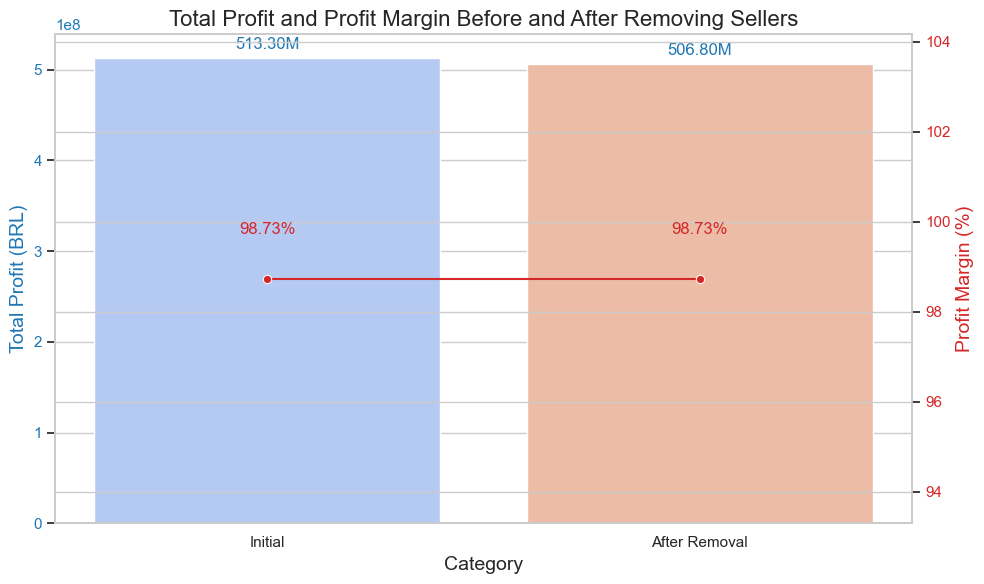

In [12]:
total_unique_sellers = len(training_data['seller_id'].unique())
sellers_to_remove = optimal_sellers_to_remove
initial_profit = initial_total_profits
maximized_profit = best_profit
initial_profit_margin = (initial_total_profits - initial_it_costs) / initial_total_profits * 100
maximized_profit_margin = best_profit_margin

# Create DataFrames for the profits and profit margins
df_combined = pd.DataFrame({
    'Category': ['Initial', 'After Removal'],
    'Total Profit (BRL)': [initial_profit, maximized_profit],
    'Profit Margin (%)': [initial_profit_margin, maximized_profit_margin]
})

# Plot the combined bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total profit on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Category', fontsize=14)
ax1.set_ylabel('Total Profit (BRL)', fontsize=14, color=color)
sns.barplot(x='Category', y='Total Profit (BRL)', data=df_combined, palette='coolwarm', ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)

# Annotate total profit values on the bars
for index, value in enumerate(df_combined['Total Profit (BRL)']):
    ax1.text(index, value + 1e7, f'{value / 1e6:.2f}M', ha='center', fontsize=12, color=color)

# Create a secondary y-axis for the profit margin
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Profit Margin (%)', fontsize=14, color=color)
sns.lineplot(x='Category', y='Profit Margin (%)', data=df_combined, color=color, marker='o', ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

# Annotate profit margin values on the line plot
for index, value in enumerate(df_combined['Profit Margin (%)']):
    ax2.text(index, value + 1, f'{value:.2f}%', ha='center', fontsize=12, color=color)

plt.title('Total Profit and Profit Margin Before and After Removing Sellers', fontsize=16)
fig.tight_layout()
plt.show()

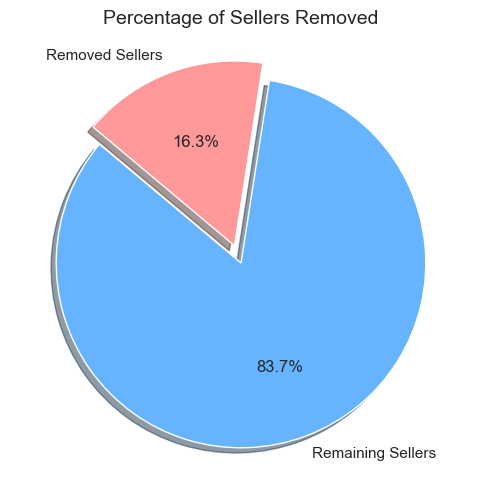

In [13]:
# Pie chart for percentage of sellers removed
labels = ['Remaining Sellers', 'Removed Sellers']
sizes = [total_unique_sellers - sellers_to_remove, sellers_to_remove]
colors = ['#66b3ff', '#ff9999']
explode = (0, 0.1)  # explode the 2nd slice (i.e. 'Removed Sellers')

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of Sellers Removed', fontsize=14)
plt.show()

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪